In [5]:
!pip install optuna

Saving Dataset_Machine_tool_wear.zip to Dataset_Machine_tool_wear (4).zip
/content/Dataset_Machine_tool_wear.csv
/content/Dataset_Machine_tool_wear.zip
/content/Dataset_Machine_tool_wear (2).zip
/content/Dataset_Machine_tool_wear (1).zip
/content/Dataset_Machine_tool_wear (3).zip
/content/Dataset_Machine_tool_wear (4).zip
/content/config_sentinel
/content/default_configs.db
/content/gce
/content/.last_opt_in_prompt.yaml
/content/hidden_gcloud_config_universe_descriptor_data_cache_configs.db
/content/.last_update_check.json
/content/.last_survey_prompt.yaml
/content/active_config
/content/config_default
/content/14.30.45.231815.log
/content/14.30.35.382199.log
/content/14.30.45.937471.log
/content/14.30.04.285207.log
/content/14.30.36.623222.log
/content/14.30.27.010422.log
/content/anscombe.json
/content/README.md
/content/mnist_test.csv
/content/mnist_train_small.csv
/content/california_housing_test.csv
/content/california_housing_train.csv
<bound method NDFrame.head of         AE_MAX

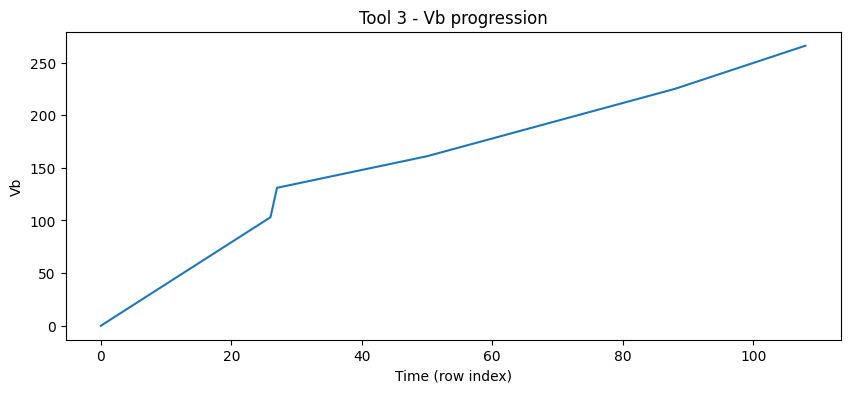

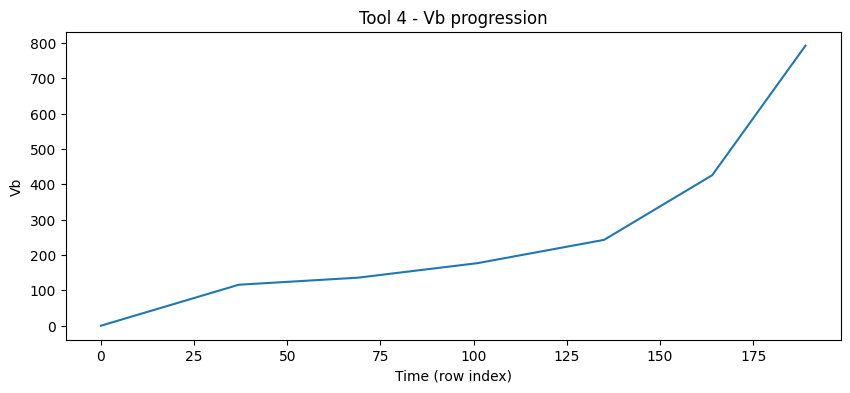

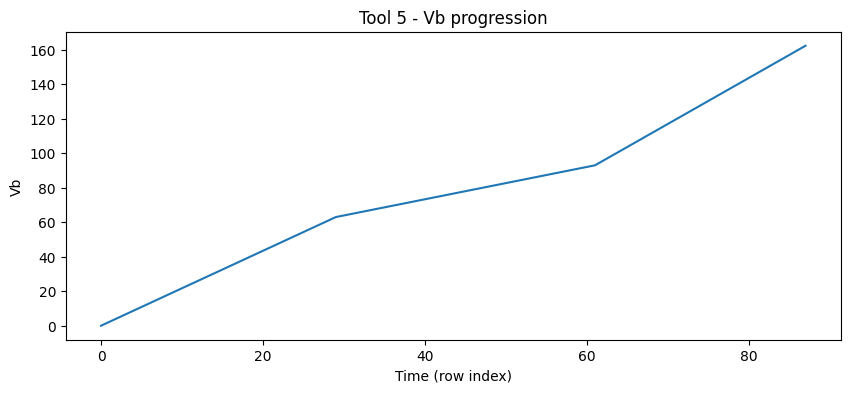

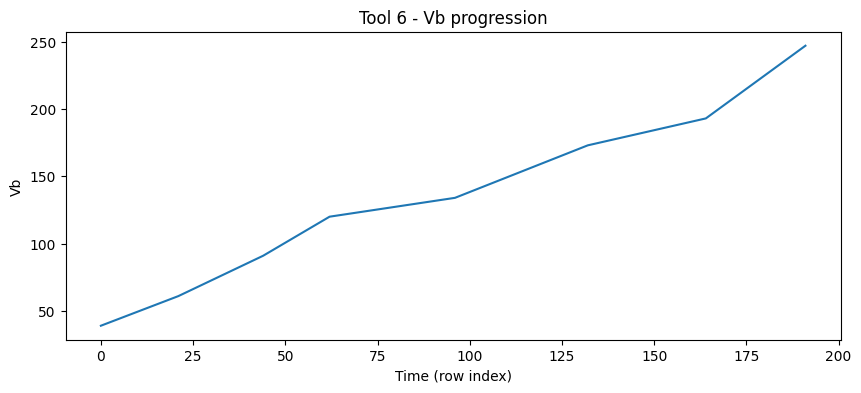

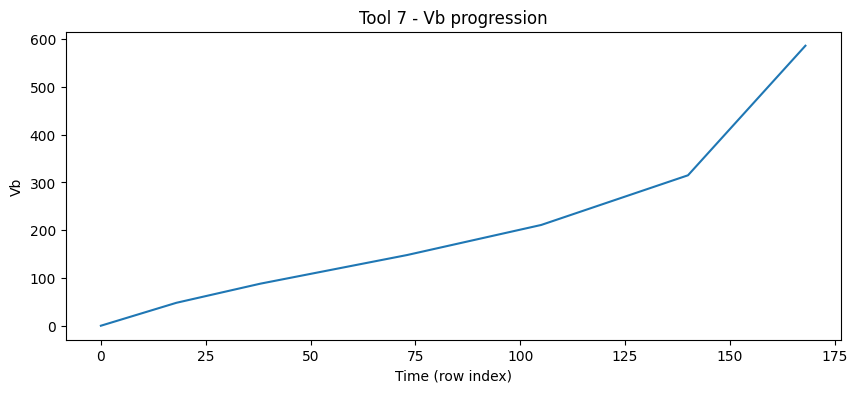

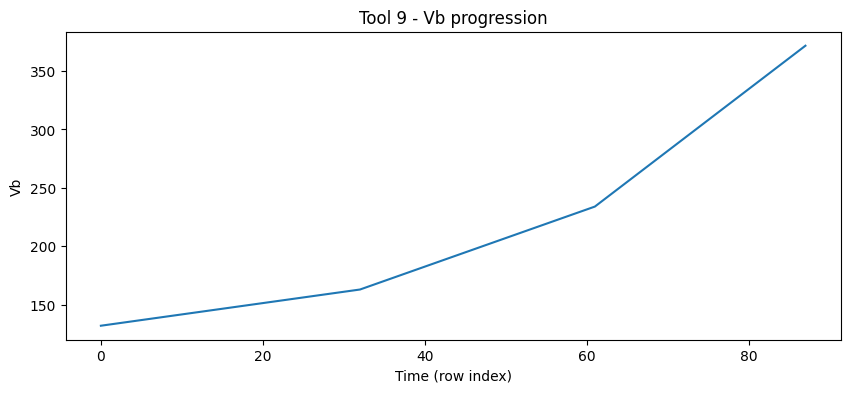

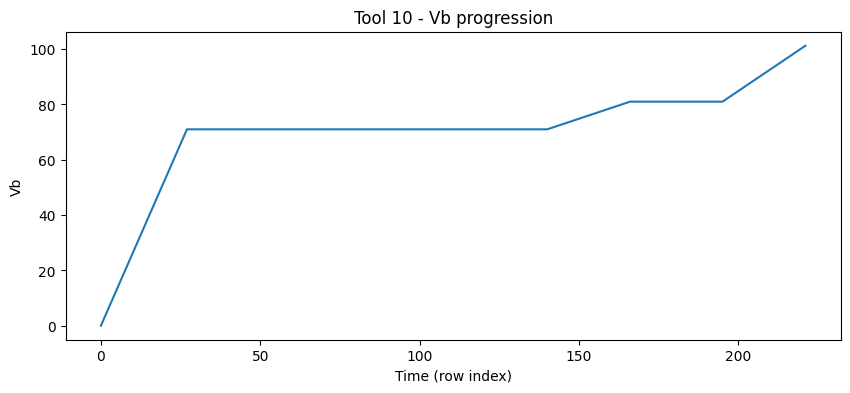

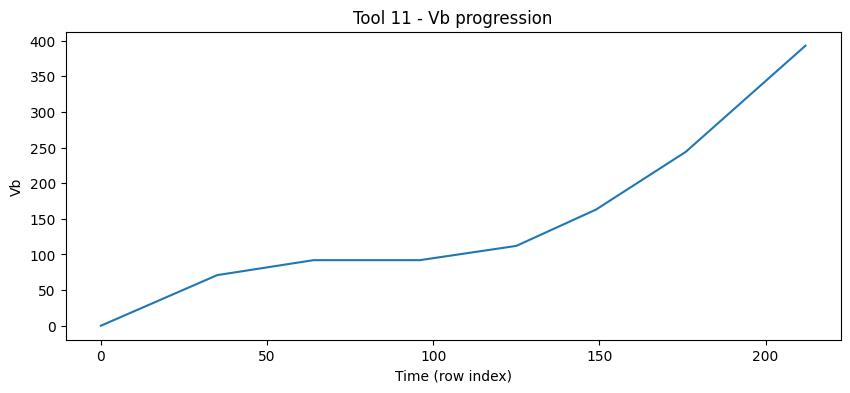

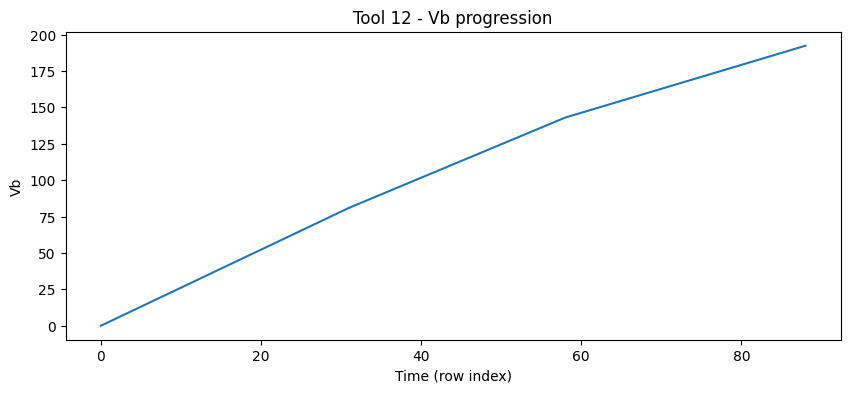

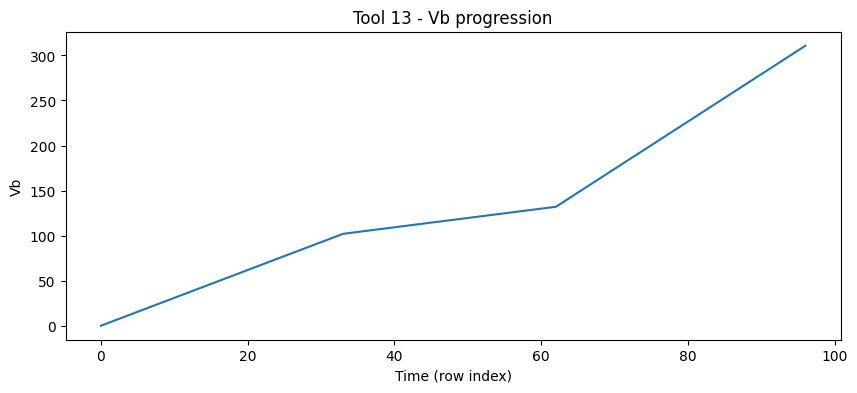

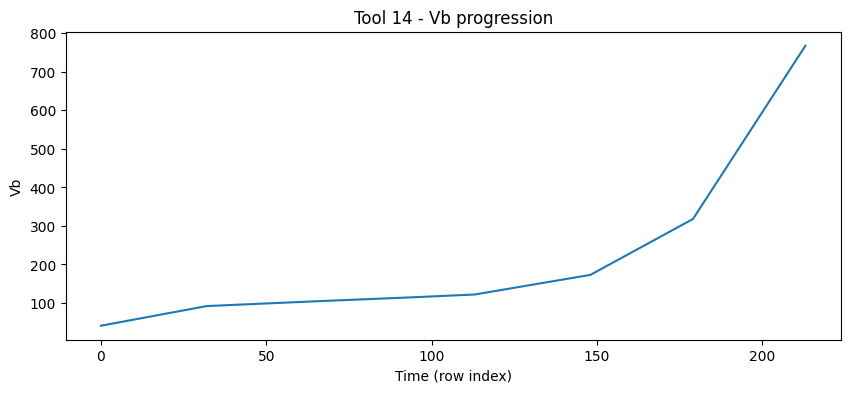

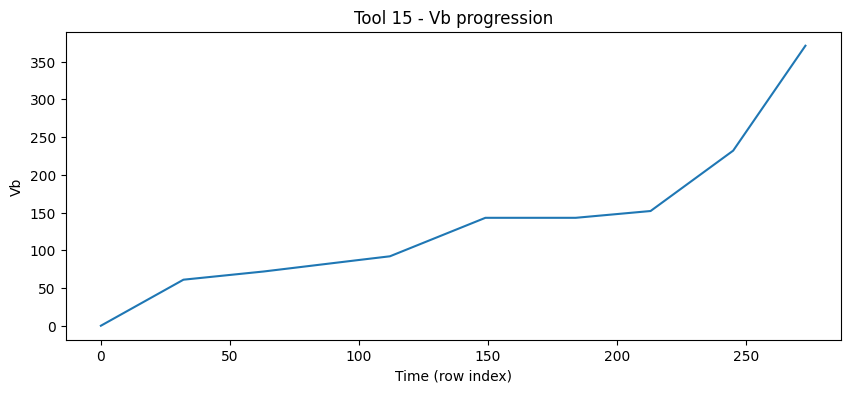

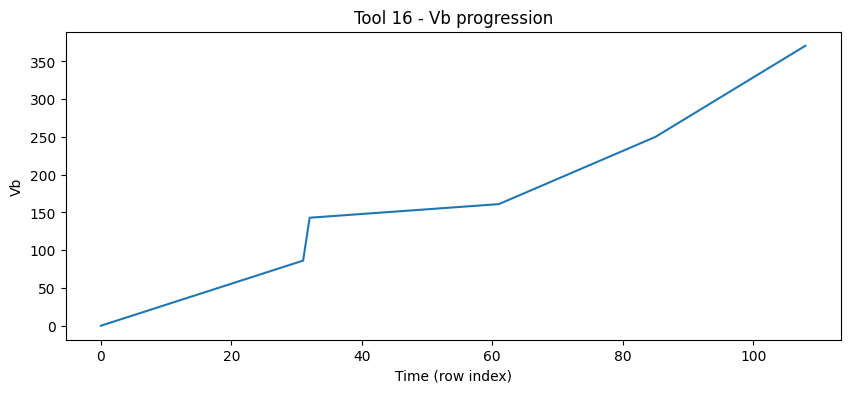

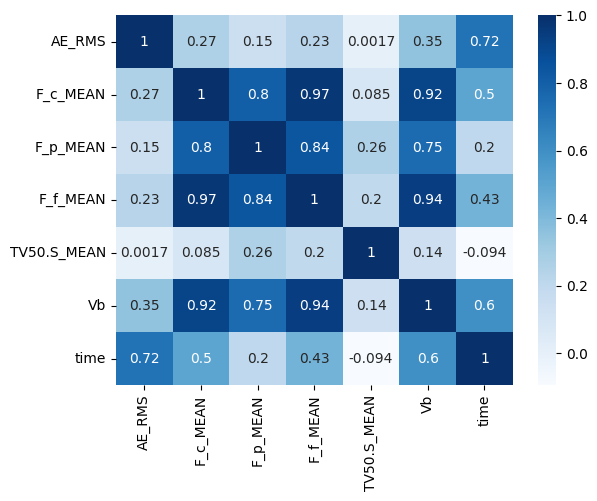

Index(['AE_MAX', 'AE_KURT', 'AE_VAR', 'AE_RMS', 'AE_C_0.1', 'AE_C_0.15',
       'AE_CF', 'Ax1_RMS', 'Ax1_SK', 'Ax1_MEAN',
       ...
       'CV3.Z_MAX', 'CV3.Z_KURT', 'CON.SV2.S', 'CON.SV2.X', 'CON.SV2.Z',
       'CON.G.FREAL', 'CON.A.SREAL.S', 'tool', 'Vb', 'time'],
      dtype='object', length=155)
[('AE_VAR', 'AE_RMS', np.float64(0.9469896249691414)), ('AE_VAR', 'AE_C_0.15', np.float64(0.927486471799909)), ('AE_RMS', 'AE_C_0.15', np.float64(0.932911061149246)), ('Ax2_RMS', 'Ax2_MAX', np.float64(0.9373648058710087)), ('Ay2_RMS', 'Ay2_MAX', np.float64(0.9759044718976038)), ('Az1_RMS', 'Az1_MAX', np.float64(0.9531269333044281)), ('Az1_SK', 'Iu_x_RMS', np.float64(0.9172012604062444)), ('Az1_SK', 'Iu_x_MAX', np.float64(0.9231380619329058)), ('Az1_SK', 'Iv_x_RMS', np.float64(0.9118563398173393)), ('Az1_SK', 'Iv_x_MAX', np.float64(0.9221636900940274)), ('Az1_SK', 'Iv_x_KURT', np.float64(0.9040309577803474)), ('F_p_RMS', 'F_p_MEAN', np.float64(0.9999851309723299)), ('F_p_RMS', 'F_p_MAX', np

In [26]:
from google.colab import files
uploaded = files.upload()

import re
import zipfile
import os

local_zip = zipfile.ZipFile('Dataset_Machine_tool_wear.zip', 'r')
local_zip.extractall('/content')
local_zip.close()

for _,_,filenames in os.walk('/content'):
  for filename in filenames:
    print(os.path.join('/content',filename))

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import optuna
import tensorflow as tf
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers , models , Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
df = pd.read_csv('/content/Dataset_Machine_tool_wear.csv')
print(df.head)
print(df['tool'].nunique())
print(df.groupby('tool').size())

df["time"] = df.groupby("tool").cumcount()
for tool_id, g in df.groupby("tool"):
    plt.figure(figsize=(10,4))
    plt.plot(g["time"], g["Vb"])
    plt.title(f"Tool {tool_id} - Vb progression")
    plt.xlabel("Time (row index)")
    plt.ylabel("Vb")
    plt.show()

df_hmap = df[['AE_RMS','F_c_MEAN','F_p_MEAN','F_f_MEAN','TV50.S_MEAN','Vb','time']].corr()
sns.heatmap(df_hmap,annot=True,cbar=True,cmap='Blues')
plt.show()

print(df.columns)
df_feature = df.copy()
df_feature.drop(['tool','time','Vb'],axis=1,inplace=True)
corr = df_feature.corr().abs()

upper = corr.where(np.triu(np.ones(corr.shape),k=1).astype(bool))
redundant_pair = [(i,j,corr.loc[i,j]) for i in upper.columns for j in upper.index if pd.notnull(upper.loc[i,j]) and upper.loc[i,j] > 0.90 ]
print(redundant_pair)

col_to_drop = []
for i,j,k in redundant_pair:
  val1 = abs(df_feature[i].corr(df['Vb']))
  val2 = abs(df_feature[j].corr(df['Vb']))
  if val1 > val2:
    col_to_drop.append(j)
  else:
    col_to_drop.append(i)

col_to_drop = list(set(col_to_drop))
print(len(col_to_drop))
df = df.drop(columns=col_to_drop)
print(df.shape)
print(df.columns)

df_ae = df[['AE_KURT','AE_RMS','AE_CF']]
df_vib = df[['Ax1_KURT', 'Ax2_KURT', 'Ay1_KURT', 'Ay2_KURT', 'Az1_KURT', 'Az2_KURT']]
df_force = df[['F_c_KURT','F_p_MAX','F_f_MAX']]
df_micro = df[['Micro_RMS','Micro_KURT']]
velocity_columns = ['Vu_s_SK', 'Vu_s_MEAN','Vu_s_MAX', 'Vu_x_SK', 'Vu_x_MEAN', 'Vv_s_RMS', 'Vv_s_SK', 'Vv_s_MEAN',
                    'Vv_s_MAX', 'Vv_x_SK', 'Vv_x_MEAN', 'Vv_x_MAX', 'Vw_s_SK', 'Vw_s_MEAN',
                    'Vw_s_MAX', 'Vw_s_KURT', 'Vw_x_SK', 'Vw_x_MEAN', 'Vw_x_KURT']
low_var_velocity = df[velocity_columns].var().sort_values().tail(10).index.tolist()
df_vel = df[low_var_velocity]

df_tv_cv = df[['TV51.S_KURT','TV2.S_KURT','TV2.X_KURT','CV3.S_MAX','CV3.X_MAX','CV3.Z_MAX']]

df['CON.SV2'] = np.sqrt(df['CON.SV2.X']**2+df['CON.SV2.Z']**2)

df_vibration = np.sqrt(np.square((df['Ax1_KURT']+df['Ax2_KURT'])/2)+np.square((df['Ay1_KURT']+df['Ay2_KURT'])/2)+np.square((df['Az1_KURT']+df['Az2_KURT'])/2))

df_final = pd.concat([
    df_ae,
    df_vibration.rename('vibration'),
    df_force,
    df_micro,
    df_vel,
    df_tv_cv,
    df[['CON.SV2','tool','CON.G.FREAL',  'time','Vb']]
], axis=1)

print(df_final.head)
print(df_final.columns)

In [48]:
df_per_tool = {}
for tool_id, g in df_final.groupby('tool'):
  df_per_tool[tool_id] = g.sort_values('time').reset_index(drop=True)
  df_per_tool[tool_id].drop(columns=['tool','time'],axis=1,inplace=True)
lookback = 50
min_row_for_test = 125
split_ratio = 0.80

def create_window(data,lookback):
  X,y = [],[]
  if data.size ==0:
    return np.array([]),np.array([])
  else:
    for i in range(len(data)-lookback):
      X.append(data[i:i+lookback,:-1])
      y.append(data[i+lookback,-1])
    return np.array(X),np.array(y)
def get_train_test_data(df_per_tool,lookback,min_row_for_test,split_ratio):
  scaler = StandardScaler()
  X_train,X_val,X_test = [],[],[]
  y_train,y_val,y_test = [],[],[]
  tool_id = list(df_per_tool.keys())
  split_idx = int(np.floor(len(tool_id)*split_ratio))
  val_idx = int(np.floor(split_idx*split_ratio))
  train_idx = tool_id[:val_idx]
  train_df = [df_per_tool[tool] for tool in train_idx]
  train_df = pd.concat(train_df,axis=0)
  fit_train_df = scaler.fit(train_df)
  for idx,(tool_id,df) in enumerate(df_per_tool.items()):
    if df.shape[0] < lookback : continue
    df = scaler.transform(df)
    X,y = create_window(df,lookback)
    if X.size > 0:
      if idx < val_idx:
        X_train.append(X)
        y_train.append(y)
      elif idx < split_idx:
        X_val.append(X)
        y_val.append(y)
      else :
        X_test.append(X)
        y_test.append(y)
  X_train = np.concatenate(X_train, axis=0) if X_train else np.array([])
  y_train = np.concatenate(y_train, axis=0) if y_train else np.array([])
  X_val = np.concatenate(X_val, axis=0) if X_val else np.array([])
  y_val = np.concatenate(y_val, axis=0) if y_val else np.array([])
  X_test = np.concatenate(X_test, axis=0) if X_test else np.array([])
  y_test = np.concatenate(y_test, axis=0) if y_test else np.array([])
  return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_data(df_per_tool,lookback,min_row_for_test,split_ratio)
print(X_train.shape)

(871, 50, 27)


Starting training...
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.5813 - val_loss: 0.0259
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0779 - val_loss: 0.0599
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0386 - val_loss: 0.0431
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0365 - val_loss: 0.0667
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0349 - val_loss: 0.0623
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0317 - val_loss: 0.0489
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0266 - val_loss: 0.0598
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0457 - val_loss: 0.0498
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0413 - val_loss: 0.0684
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0259 - val_loss: 0.0790
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0314 - val_loss: 0.0903
Epoch 12/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 

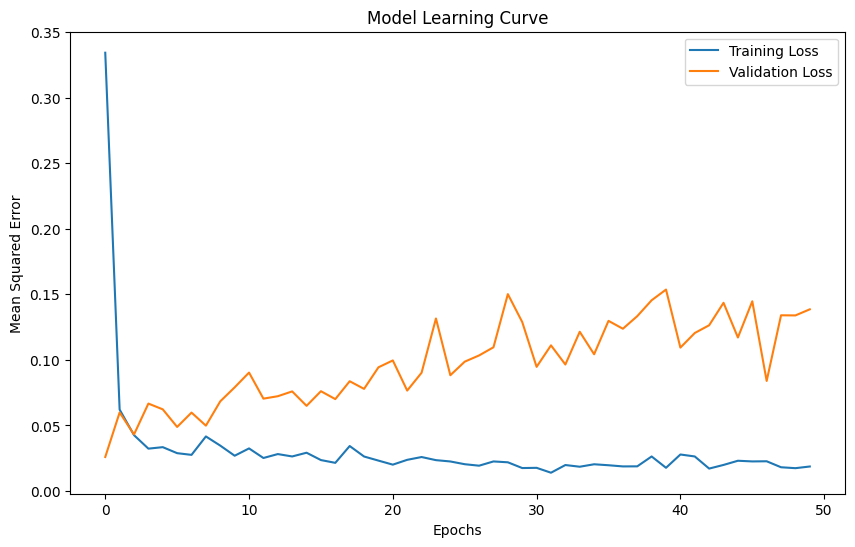

Model: "functional_287"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_289 (InputLayer)    │ (None, 50, 27)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_block_286 (LSTMBlock)      │ (None, 1)              │       100,513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 301,541 (1.15 MB)

 Trainable params: 100,513 (392.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 201,028 (785.27 KB)

In [49]:
class LSTMBlock(layers.Layer):
  def __init__(self,units_1,units_2,activation,dropout,return_sequences=True):
    super(LSTMBlock,self).__init__()
    self.block_1 = layers.LSTM(units=units_1,activation=activation,return_sequences=return_sequences)
    self.dropout = layers.Dropout(dropout)
    self.block_2 = layers.LSTM(units=units_2,activation=activation,return_sequences=False)
    self.block_final = layers.Dense(units=1,activation='linear')
  def call(self,inputs,training=False):
    x = self.block_1(inputs)
    x = self.dropout(x,training=training)
    x = self.block_2(x)
    x = self.dropout(x,training=training)
    x = self.block_final(x)
    return x

def build_lstm(input_shape,units_1=128,units_2=32,activation='tanh',dropout=0.25):
  inputs = Input(input_shape)
  outputs = LSTMBlock(units_1=units_1,units_2=units_2,activation=activation,dropout=dropout)(inputs)
  base_model = models.Model(inputs = inputs,outputs = outputs)
  base_model.compile(optimizer='adam', loss='mean_squared_error')
  return base_model

input_shape = (X_train.shape[1], X_train.shape[2])
base_model = build_lstm(input_shape)
print("Starting training...")
base_model_history = base_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

plt.figure(figsize=(10, 6))
plt.plot(base_model_history.history['loss'], label='Training Loss')
plt.plot(base_model_history.history['val_loss'], label='Validation Loss')
plt.title('Model Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()
base_model.summary()


In [50]:
search_space  = {
  'units_1' : {'min':16 , 'max':128 , 'step':16},
  'units_2' : {'min':16 , 'max':128 , 'step':16},
  'dropout_rate' : {'min':0.1 , 'max':0.5},
  'weight_decay' : {'min':1e-5 , 'max':1e-2},
  'learning_rate' : {'min':1e-4 , 'max':1e-2}
}


def objective(trial):
  units_1 = trial.suggest_int('units_1', search_space['units_1']['min'], search_space['units_1']['max'], search_space['units_1']['step'])
  units_2 = trial.suggest_int('units_2', search_space['units_2']['min'], search_space['units_2']['max'], search_space['units_2']['step'])
  dropout_rate = trial.suggest_float('dropout_rate', search_space['dropout_rate']['min'], search_space['dropout_rate']['max'])
  learning_rate = trial.suggest_float('learning_rate', search_space['learning_rate']['min'], search_space['learning_rate']['max'], log=True)
  weight_decay = trial.suggest_float('weight_decay', search_space['weight_decay']['min'], search_space['weight_decay']['max'], log=True)

  model = build_lstm(input_shape,units_1=units_1,units_2=units_2,dropout=dropout_rate)
  model.compile(optimizer=AdamW(learning_rate=learning_rate, weight_decay=weight_decay), loss='mean_squared_error')
  early_stopping = EarlyStopping(monitor='val_loss',patience = 4,restore_best_weights=True)
  model_history = model.fit(X_train,y_train,batch_size = 32,epochs = 30,validation_data=(X_val,y_val),callbacks=[early_stopping])
  val_loss = model_history.history['val_loss'][-1]
  return val_loss

print("Searching for the perfect configuration...")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=40)
print("-" * 50)
print("BEST HYPERPARAMETERS:")
print(study.best_params)
print(f"Best Validation Loss: {study.best_value}")
lstm_final_model = build_lstm(input_shape,units_1=study.best_params['units_1'],units_2=study.best_params['units_2'],dropout=study.best_params['dropout_rate'])
lstm_early_stopping = EarlyStopping(monitor='val_loss',patience = 4,restore_best_weights=True)
lstm_final_model_history = lstm_final_model.fit(X_train,y_train,batch_size=32,epochs=50,validation_data=(X_val,y_val),callbacks=lstm_early_stopping)

print("\nEvaluated on Held-Out Test Data:")
test_loss = lstm_final_model.evaluate(X_test, y_test, verbose=0)
print(f"Final Test MSE (Scaled): {test_loss:.4f}")

[I 2025-12-01 12:51:14,949] A new study created in memory with name: no-name-1ea2ca5e-e7bf-4a3f-95da-f7d7387793cc


Searching for the perfect configuration...


/tmp/ipython-input-3782484644.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  units_1 = trial.suggest_int('units_1', search_space['units_1']['min'], search_space['units_1']['max'], search_space['units_1']['step'])
/tmp/ipython-input-3782484644.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specifica

Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.3483 - val_loss: 0.1255
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0494 - val_loss: 0.1198
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0376 - val_loss: 0.0811
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0432 - val_loss: 0.0823
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0311 - val_loss: 0.1224
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0263 - val_loss: 0.1083
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0220 - val_loss: 0.1060


[I 2025-12-01 12:51:24,343] Trial 0 finished with value: 0.10597884654998779 and parameters: {'units_1': 64, 'units_2': 48, 'dropout_rate': 0.18898169994222902, 'learning_rate': 0.0032523114329702416, 'weight_decay': 0.0031829021920745174}. Best is trial 0 with value: 0.10597884654998779.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.5184 - val_loss: 0.0535
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0540 - val_loss: 0.0324
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0334 - val_loss: 0.0492
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0373 - val_loss: 0.0409
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0347 - val_loss: 0.0579
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0256 - val_loss: 0.0663


[I 2025-12-01 12:51:28,853] Trial 1 finished with value: 0.066325344145298 and parameters: {'units_1': 32, 'units_2': 96, 'dropout_rate': 0.2060695720602151, 'learning_rate': 0.0052173692069818174, 'weight_decay': 1.0452686432900537e-05}. Best is trial 1 with value: 0.066325344145298.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.2232 - val_loss: 0.1190
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0957 - val_loss: 0.1336
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0618 - val_loss: 0.1361
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0535 - val_loss: 0.0556
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0501 - val_loss: 0.0745
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0490 - val_loss: 0.1105
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0503 - val_loss: 0.0878
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0332 - val_loss: 0.1944


[I 2025-12-01 12:51:34,597] Trial 2 finished with value: 0.1943667232990265 and parameters: {'units_1': 112, 'units_2': 32, 'dropout_rate': 0.31431388315799047, 'learning_rate': 0.004796223952357978, 'weight_decay': 0.009257835718007245}. Best is trial 1 with value: 0.066325344145298.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.5882 - val_loss: 0.0636
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0396 - val_loss: 0.0568
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0214 - val_loss: 0.0415
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0162 - val_loss: 0.0375
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0186 - val_loss: 0.0613
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0174 - val_loss: 0.0526
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0152 - val_loss: 0.0366
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0145 - val_loss: 0.0645
Epoch 9/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0214 - val_loss: 0.0375
Epoch 10/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0150 - val_loss: 0.0566
Epoch 11/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0190 - val_loss: 0.0368


[I 2025-12-01 12:51:40,385] Trial 3 finished with value: 0.03676631301641464 and parameters: {'units_1': 48, 'units_2': 112, 'dropout_rate': 0.16674046740748694, 'learning_rate': 0.0017245855418042283, 'weight_decay': 0.0006323204485634075}. Best is trial 3 with value: 0.03676631301641464.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.5115 - val_loss: 0.1362
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0631 - val_loss: 0.1065
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0371 - val_loss: 0.0689
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0328 - val_loss: 0.0786
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0254 - val_loss: 0.0738
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0350 - val_loss: 0.0612
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0331 - val_loss: 0.0871
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0264 - val_loss: 0.0665
Epoch 9/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0257 - val_loss: 0.0770
Epoch 10/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0230 - val_loss: 0.0852


[I 2025-12-01 12:51:47,025] Trial 4 finished with value: 0.0851786881685257 and parameters: {'units_1': 32, 'units_2': 32, 'dropout_rate': 0.18261169237569544, 'learning_rate': 0.0033044710007736388, 'weight_decay': 3.393673476879223e-05}. Best is trial 3 with value: 0.03676631301641464.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.6562 - val_loss: 0.1108
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1610 - val_loss: 0.0846
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1341 - val_loss: 0.0702
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0643 - val_loss: 0.0856
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0783 - val_loss: 0.0743
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0882 - val_loss: 0.0624
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0660 - val_loss: 0.0699
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0700 - val_loss: 0.0837
Epoch 9/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0605 - val_loss: 0.0880
Epoch 10/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0576 - val_loss: 0.0984


[I 2025-12-01 12:51:58,990] Trial 5 finished with value: 0.0983569547533989 and parameters: {'units_1': 80, 'units_2': 16, 'dropout_rate': 0.3535652945344172, 'learning_rate': 0.0015822603724061288, 'weight_decay': 4.475486455746386e-05}. Best is trial 3 with value: 0.03676631301641464.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.7447 - val_loss: 0.1550
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1360 - val_loss: 0.0966
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0497 - val_loss: 0.1389
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0445 - val_loss: 0.1537
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0294 - val_loss: 0.1457
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0336 - val_loss: 0.1636


[I 2025-12-01 12:52:03,583] Trial 6 finished with value: 0.16356827318668365 and parameters: {'units_1': 64, 'units_2': 32, 'dropout_rate': 0.13689084054580003, 'learning_rate': 0.0005046377109834534, 'weight_decay': 0.008650665629600074}. Best is trial 3 with value: 0.03676631301641464.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.6253 - val_loss: 0.0502
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0654 - val_loss: 0.0465
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0224 - val_loss: 0.0390
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0158 - val_loss: 0.0351
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0106 - val_loss: 0.0361
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0101 - val_loss: 0.0338
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0114 - val_loss: 0.0353
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0095 - val_loss: 0.0356
Epoch 9/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0110 - val_loss: 0.0369
Epoch 10/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0113 - val_loss: 0.0361


[I 2025-12-01 12:52:10,040] Trial 7 finished with value: 0.036063339561223984 and parameters: {'units_1': 96, 'units_2': 112, 'dropout_rate': 0.14835034020915489, 'learning_rate': 0.00034207769516419025, 'weight_decay': 1.106445890575884e-05}. Best is trial 7 with value: 0.036063339561223984.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 1.0838 - val_loss: 0.1555
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5106 - val_loss: 0.3153
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0929 - val_loss: 0.2119
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0581 - val_loss: 0.1691
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0319 - val_loss: 0.1324
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0239 - val_loss: 0.1201
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0178 - val_loss: 0.1045
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0147 - val_loss: 0.0972
Epoch 9/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0112 - val_loss: 0.0929
Epoch 10/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0110 - val_loss: 0.0840
Epoch 11/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0117 - val_loss: 0.0863
Epoch 12/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0

[I 2025-12-01 12:52:17,916] Trial 8 finished with value: 0.08657681941986084 and parameters: {'units_1': 32, 'units_2': 112, 'dropout_rate': 0.11105038527122156, 'learning_rate': 0.00016872956373264987, 'weight_decay': 0.0009599076062909714}. Best is trial 7 with value: 0.036063339561223984.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.5699 - val_loss: 0.0966
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1167 - val_loss: 0.1023
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0505 - val_loss: 0.0829
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0527 - val_loss: 0.0866
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0477 - val_loss: 0.1688
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0469 - val_loss: 0.0824
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0615 - val_loss: 0.0594
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0340 - val_loss: 0.1017
Epoch 9/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0301 - val_loss: 0.0986
Epoch 10/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0267 - val_loss: 0.0536
Epoch 11/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0400 - val_loss: 0.0519
Epoch 12/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0

[I 2025-12-01 12:52:26,424] Trial 9 finished with value: 0.07230224460363388 and parameters: {'units_1': 16, 'units_2': 128, 'dropout_rate': 0.3337174944843633, 'learning_rate': 0.009296380231110459, 'weight_decay': 3.521764073912534e-05}. Best is trial 7 with value: 0.036063339561223984.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.6836 - val_loss: 0.0900
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1375 - val_loss: 0.0534
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0811 - val_loss: 0.0821
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0785 - val_loss: 0.0758
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0759 - val_loss: 0.0795
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0601 - val_loss: 0.0792


[I 2025-12-01 12:52:30,920] Trial 10 finished with value: 0.07916659861803055 and parameters: {'units_1': 128, 'units_2': 80, 'dropout_rate': 0.4957535279282178, 'learning_rate': 0.0003457163298229791, 'weight_decay': 0.00016786004882961777}. Best is trial 7 with value: 0.036063339561223984.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.3813 - val_loss: 0.2228
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0489 - val_loss: 0.0600
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0220 - val_loss: 0.0890
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0255 - val_loss: 0.0584
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0300 - val_loss: 0.0863
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0186 - val_loss: 0.0841
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0163 - val_loss: 0.0744
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0224 - val_loss: 0.0704


[I 2025-12-01 12:52:37,020] Trial 11 finished with value: 0.07036746293306351 and parameters: {'units_1': 96, 'units_2': 128, 'dropout_rate': 0.24896985766622481, 'learning_rate': 0.0008147127891821334, 'weight_decay': 0.00041640554754868685}. Best is trial 7 with value: 0.036063339561223984.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.0007 - val_loss: 0.2652
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4376 - val_loss: 0.1927
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1465 - val_loss: 0.1079
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0690 - val_loss: 0.1485
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0497 - val_loss: 0.1731
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0332 - val_loss: 0.2047
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0285 - val_loss: 0.2202


[I 2025-12-01 12:52:41,698] Trial 12 finished with value: 0.22021715342998505 and parameters: {'units_1': 80, 'units_2': 96, 'dropout_rate': 0.24610356536871522, 'learning_rate': 0.00012178950799178962, 'weight_decay': 0.00021280418207123922}. Best is trial 7 with value: 0.036063339561223984.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.4977 - val_loss: 0.0214
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0556 - val_loss: 0.0383
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0144 - val_loss: 0.0416
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0118 - val_loss: 0.0354
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0134 - val_loss: 0.0373


[I 2025-12-01 12:52:46,380] Trial 13 finished with value: 0.03727290406823158 and parameters: {'units_1': 48, 'units_2': 64, 'dropout_rate': 0.10325115501690024, 'learning_rate': 0.0013957730229644232, 'weight_decay': 0.0010521746235430689}. Best is trial 7 with value: 0.036063339561223984.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.8021 - val_loss: 0.1110
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0801 - val_loss: 0.0604
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0337 - val_loss: 0.0454
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0235 - val_loss: 0.0377
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0145 - val_loss: 0.0413
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0140 - val_loss: 0.0398
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0138 - val_loss: 0.0377
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0141 - val_loss: 0.0355
Epoch 9/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0134 - val_loss: 0.0352
Epoch 10/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0092 - val_loss: 0.0380
Epoch 11/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0122 - val_loss: 0.0368
Epoch 12/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0

[I 2025-12-01 12:52:53,165] Trial 14 finished with value: 0.03527118265628815 and parameters: {'units_1': 96, 'units_2': 112, 'dropout_rate': 0.16048658918124453, 'learning_rate': 0.00029009517917285644, 'weight_decay': 0.00010467942012619152}. Best is trial 14 with value: 0.03527118265628815.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.9796 - val_loss: 0.0423
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1235 - val_loss: 0.0295
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0611 - val_loss: 0.0527
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0469 - val_loss: 0.0652
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0477 - val_loss: 0.0726
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0442 - val_loss: 0.0682


[I 2025-12-01 12:52:58,484] Trial 15 finished with value: 0.06818380951881409 and parameters: {'units_1': 112, 'units_2': 80, 'dropout_rate': 0.38520139576416823, 'learning_rate': 0.0002597315031430323, 'weight_decay': 9.021880913689378e-05}. Best is trial 14 with value: 0.03527118265628815.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.3968 - val_loss: 0.0239
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0494 - val_loss: 0.0667
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0270 - val_loss: 0.1016
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0294 - val_loss: 0.0637
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0234 - val_loss: 0.0498


[I 2025-12-01 12:53:02,865] Trial 16 finished with value: 0.04981796070933342 and parameters: {'units_1': 96, 'units_2': 112, 'dropout_rate': 0.2657820620502085, 'learning_rate': 0.0006843120487728714, 'weight_decay': 1.0579459982059884e-05}. Best is trial 14 with value: 0.03527118265628815.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.7134 - val_loss: 0.0338
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0876 - val_loss: 0.0581
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0302 - val_loss: 0.0956
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0188 - val_loss: 0.0943
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0158 - val_loss: 0.1005


[I 2025-12-01 12:53:06,879] Trial 17 finished with value: 0.10053681582212448 and parameters: {'units_1': 128, 'units_2': 96, 'dropout_rate': 0.15013318285333976, 'learning_rate': 0.0002470570760124238, 'weight_decay': 2.274351677100926e-05}. Best is trial 14 with value: 0.03527118265628815.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.9148 - val_loss: 0.0466
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0653 - val_loss: 0.0739
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0224 - val_loss: 0.1154
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0185 - val_loss: 0.1146
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0191 - val_loss: 0.1114


[I 2025-12-01 12:53:11,975] Trial 18 finished with value: 0.11138550192117691 and parameters: {'units_1': 96, 'units_2': 128, 'dropout_rate': 0.2204426498625119, 'learning_rate': 0.00036071234215146944, 'weight_decay': 9.546947848664082e-05}. Best is trial 14 with value: 0.03527118265628815.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.8871 - val_loss: 0.0788
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2334 - val_loss: 0.0632
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1302 - val_loss: 0.0702
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0839 - val_loss: 0.0636
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0620 - val_loss: 0.0568
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0535 - val_loss: 0.0546
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0575 - val_loss: 0.0613
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0481 - val_loss: 0.0621
Epoch 9/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0468 - val_loss: 0.0614
Epoch 10/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0599 - val_loss: 0.0628


[I 2025-12-01 12:53:17,571] Trial 19 finished with value: 0.06280560791492462 and parameters: {'units_1': 112, 'units_2': 64, 'dropout_rate': 0.4315253910258857, 'learning_rate': 0.00019275349244147078, 'weight_decay': 6.853306302586957e-05}. Best is trial 14 with value: 0.03527118265628815.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.9486 - val_loss: 0.0730
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3975 - val_loss: 0.0295
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0913 - val_loss: 0.0257
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0565 - val_loss: 0.0210
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0421 - val_loss: 0.0264
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0335 - val_loss: 0.0321
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0302 - val_loss: 0.0345
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0275 - val_loss: 0.0389


[I 2025-12-01 12:53:23,850] Trial 20 finished with value: 0.03886447474360466 and parameters: {'units_1': 80, 'units_2': 112, 'dropout_rate': 0.2820423370688122, 'learning_rate': 0.00011396013397152575, 'weight_decay': 1.7088636284664012e-05}. Best is trial 14 with value: 0.03527118265628815.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.5995 - val_loss: 0.0654
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0417 - val_loss: 0.0760
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0236 - val_loss: 0.0738
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0174 - val_loss: 0.0924
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0137 - val_loss: 0.0666


[I 2025-12-01 12:53:28,433] Trial 21 finished with value: 0.0665678009390831 and parameters: {'units_1': 48, 'units_2': 112, 'dropout_rate': 0.16266545077000746, 'learning_rate': 0.0013605378237611786, 'weight_decay': 0.0004984656282351226}. Best is trial 14 with value: 0.03527118265628815.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.6099 - val_loss: 0.0460
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0697 - val_loss: 0.0233
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0317 - val_loss: 0.0296
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0178 - val_loss: 0.0295
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0148 - val_loss: 0.0316
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0146 - val_loss: 0.0373


[I 2025-12-01 12:53:32,672] Trial 22 finished with value: 0.03733034059405327 and parameters: {'units_1': 64, 'units_2': 96, 'dropout_rate': 0.1405660794860527, 'learning_rate': 0.00047796502492165167, 'weight_decay': 0.0011032593477491308}. Best is trial 14 with value: 0.03527118265628815.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.3686 - val_loss: 0.0199
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0522 - val_loss: 0.0765
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0282 - val_loss: 0.0672
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0162 - val_loss: 0.0588
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0191 - val_loss: 0.0557


[I 2025-12-01 12:53:37,210] Trial 23 finished with value: 0.05566859617829323 and parameters: {'units_1': 96, 'units_2': 128, 'dropout_rate': 0.21999626146591525, 'learning_rate': 0.001016301333584486, 'weight_decay': 0.00022133232092366864}. Best is trial 14 with value: 0.03527118265628815.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.4767 - val_loss: 0.0665
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0462 - val_loss: 0.0552
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0222 - val_loss: 0.0566
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0153 - val_loss: 0.0586
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0300 - val_loss: 0.0415
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0306 - val_loss: 0.0443
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0316 - val_loss: 0.0352
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0244 - val_loss: 0.0429
Epoch 9/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0134 - val_loss: 0.0393
Epoch 10/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0265 - val_loss: 0.0617
Epoch 11/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0181 - val_loss: 0.0516


[I 2025-12-01 12:53:43,059] Trial 24 finished with value: 0.05163243040442467 and parameters: {'units_1': 48, 'units_2': 112, 'dropout_rate': 0.18411670954309822, 'learning_rate': 0.002282280071569665, 'weight_decay': 0.002235958635202972}. Best is trial 14 with value: 0.03527118265628815.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.7031 - val_loss: 0.0378
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0563 - val_loss: 0.0812
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0186 - val_loss: 0.1221
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0212 - val_loss: 0.0943
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0136 - val_loss: 0.1081


[I 2025-12-01 12:53:47,683] Trial 25 finished with value: 0.10808239132165909 and parameters: {'units_1': 80, 'units_2': 80, 'dropout_rate': 0.1284792664992134, 'learning_rate': 0.0005140827955415453, 'weight_decay': 0.0004872211813541479}. Best is trial 14 with value: 0.03527118265628815.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.4626 - val_loss: 0.0898
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0409 - val_loss: 0.0581
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0194 - val_loss: 0.0616
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0193 - val_loss: 0.0671
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0143 - val_loss: 0.0368
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0121 - val_loss: 0.0436
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0156 - val_loss: 0.0511
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0115 - val_loss: 0.0433
Epoch 9/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0148 - val_loss: 0.0346
Epoch 10/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0193 - val_loss: 0.0360
Epoch 11/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0127 - val_loss: 0.0396
Epoch 12/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0

[I 2025-12-01 12:53:54,135] Trial 26 finished with value: 0.03836652263998985 and parameters: {'units_1': 112, 'units_2': 96, 'dropout_rate': 0.16953130156078902, 'learning_rate': 0.0008961888197179827, 'weight_decay': 0.00011902357629927989}. Best is trial 14 with value: 0.03527118265628815.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.4263 - val_loss: 0.0824
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0944 - val_loss: 0.0434
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0471 - val_loss: 0.0813
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0332 - val_loss: 0.0910
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0240 - val_loss: 0.0878
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0251 - val_loss: 0.0831


[I 2025-12-01 12:53:59,380] Trial 27 finished with value: 0.08308681100606918 and parameters: {'units_1': 16, 'units_2': 112, 'dropout_rate': 0.229048089168073, 'learning_rate': 0.0019856576326575943, 'weight_decay': 0.0022114889829122097}. Best is trial 14 with value: 0.03527118265628815.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.7807 - val_loss: 0.1180
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0757 - val_loss: 0.0543
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0431 - val_loss: 0.0442
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0271 - val_loss: 0.0446
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0235 - val_loss: 0.0472
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0236 - val_loss: 0.0358
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0209 - val_loss: 0.0388
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0209 - val_loss: 0.0428
Epoch 9/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0206 - val_loss: 0.0493
Epoch 10/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0155 - val_loss: 0.0402


[I 2025-12-01 12:54:05,454] Trial 28 finished with value: 0.04023898020386696 and parameters: {'units_1': 96, 'units_2': 128, 'dropout_rate': 0.29231669311572334, 'learning_rate': 0.0003547734776547288, 'weight_decay': 0.0002803492672918926}. Best is trial 14 with value: 0.03527118265628815.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.7168 - val_loss: 0.2882
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2665 - val_loss: 0.2587
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0980 - val_loss: 0.2149
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0508 - val_loss: 0.2257
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0468 - val_loss: 0.2522
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0359 - val_loss: 0.2796
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0275 - val_loss: 0.2704


[I 2025-12-01 12:54:10,698] Trial 29 finished with value: 0.27040162682533264 and parameters: {'units_1': 64, 'units_2': 64, 'dropout_rate': 0.19419933309276544, 'learning_rate': 0.00018430165778115428, 'weight_decay': 0.0006582405232381205}. Best is trial 14 with value: 0.03527118265628815.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.4353 - val_loss: 0.0591
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0472 - val_loss: 0.0905
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0167 - val_loss: 0.0908
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0141 - val_loss: 0.0809
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0161 - val_loss: 0.0910


[I 2025-12-01 12:54:15,257] Trial 30 finished with value: 0.09101983904838562 and parameters: {'units_1': 48, 'units_2': 80, 'dropout_rate': 0.10509807969655881, 'learning_rate': 0.0006431905592188864, 'weight_decay': 0.004633712370897355}. Best is trial 14 with value: 0.03527118265628815.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.7130 - val_loss: 0.0620
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0402 - val_loss: 0.1373
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0194 - val_loss: 0.1336
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0201 - val_loss: 0.1113
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0160 - val_loss: 0.1306


[I 2025-12-01 12:54:19,402] Trial 31 finished with value: 0.1305920034646988 and parameters: {'units_1': 48, 'units_2': 48, 'dropout_rate': 0.10122953005905279, 'learning_rate': 0.0013651313097049504, 'weight_decay': 0.001176838983118983}. Best is trial 14 with value: 0.03527118265628815.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.4920 - val_loss: 0.0511
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0511 - val_loss: 0.0799
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0242 - val_loss: 0.0718
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0269 - val_loss: 0.0804
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0306 - val_loss: 0.0797


[I 2025-12-01 12:54:24,385] Trial 32 finished with value: 0.07974252849817276 and parameters: {'units_1': 32, 'units_2': 64, 'dropout_rate': 0.1285155995289285, 'learning_rate': 0.0025567156886053917, 'weight_decay': 0.0017109199879656405}. Best is trial 14 with value: 0.03527118265628815.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.2576 - val_loss: 0.1021
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0480 - val_loss: 0.0783
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0381 - val_loss: 0.0587
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0248 - val_loss: 0.0685
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0262 - val_loss: 0.0628
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0199 - val_loss: 0.0465
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0241 - val_loss: 0.0653
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0172 - val_loss: 0.0419
Epoch 9/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0222 - val_loss: 0.0338
Epoch 10/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0219 - val_loss: 0.0584
Epoch 11/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0242 - val_loss: 0.0541
Epoch 12/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0

[I 2025-12-01 12:54:31,375] Trial 33 finished with value: 0.033889781683683395 and parameters: {'units_1': 64, 'units_2': 48, 'dropout_rate': 0.15924673816262064, 'learning_rate': 0.0039278241529321235, 'weight_decay': 0.0007526627678772247}. Best is trial 33 with value: 0.033889781683683395.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.2769 - val_loss: 0.0418
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0762 - val_loss: 0.0942
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0439 - val_loss: 0.0906
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0306 - val_loss: 0.0996
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0276 - val_loss: 0.1080


[I 2025-12-01 12:54:36,116] Trial 34 finished with value: 0.1079801395535469 and parameters: {'units_1': 64, 'units_2': 48, 'dropout_rate': 0.2016693218640349, 'learning_rate': 0.005085723835900367, 'weight_decay': 0.0007058192758714046}. Best is trial 33 with value: 0.033889781683683395.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.4426 - val_loss: 0.1505
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0772 - val_loss: 0.0763
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0561 - val_loss: 0.0428
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0364 - val_loss: 0.0251
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0407 - val_loss: 0.0530
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0434 - val_loss: 0.0365
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0379 - val_loss: 0.0442
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0342 - val_loss: 0.0358


[I 2025-12-01 12:54:41,252] Trial 35 finished with value: 0.03581609949469566 and parameters: {'units_1': 80, 'units_2': 16, 'dropout_rate': 0.16729401083731815, 'learning_rate': 0.0036070555762756883, 'weight_decay': 6.062144432632099e-05}. Best is trial 33 with value: 0.033889781683683395.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.4139 - val_loss: 0.0345
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0688 - val_loss: 0.0740
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0452 - val_loss: 0.0335
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0548 - val_loss: 0.0397
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0355 - val_loss: 0.0383
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0390 - val_loss: 0.0541
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0378 - val_loss: 0.0732


[I 2025-12-01 12:54:46,268] Trial 36 finished with value: 0.07320215553045273 and parameters: {'units_1': 80, 'units_2': 16, 'dropout_rate': 0.1608765899278289, 'learning_rate': 0.003783979174420146, 'weight_decay': 6.862283537866341e-05}. Best is trial 33 with value: 0.033889781683683395.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.3534 - val_loss: 0.2632
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0836 - val_loss: 0.1331
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0800 - val_loss: 0.0945
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0385 - val_loss: 0.2153
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0400 - val_loss: 0.1976
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0379 - val_loss: 0.1364
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0263 - val_loss: 0.1659


[I 2025-12-01 12:54:50,958] Trial 37 finished with value: 0.16585777699947357 and parameters: {'units_1': 96, 'units_2': 16, 'dropout_rate': 0.1817963122611601, 'learning_rate': 0.0060727804184991414, 'weight_decay': 1.865853326723415e-05}. Best is trial 33 with value: 0.033889781683683395.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.3465 - val_loss: 0.0865
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0576 - val_loss: 0.1271
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0519 - val_loss: 0.0544
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0363 - val_loss: 0.1964
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0274 - val_loss: 0.2235
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0280 - val_loss: 0.0824
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0318 - val_loss: 0.1191


[I 2025-12-01 12:54:55,741] Trial 38 finished with value: 0.11910540610551834 and parameters: {'units_1': 112, 'units_2': 32, 'dropout_rate': 0.20894722862042386, 'learning_rate': 0.007904980740714234, 'weight_decay': 4.3887132992868923e-05}. Best is trial 33 with value: 0.033889781683683395.


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.5464 - val_loss: 0.0833
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0313 - val_loss: 0.0692
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0266 - val_loss: 0.1104
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0305 - val_loss: 0.0766
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0229 - val_loss: 0.0911
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0220 - val_loss: 0.0991


[I 2025-12-01 12:55:01,212] Trial 39 finished with value: 0.09908880293369293 and parameters: {'units_1': 80, 'units_2': 48, 'dropout_rate': 0.12752031652715404, 'learning_rate': 0.003509033893836258, 'weight_decay': 1.1417286470523809e-05}. Best is trial 33 with value: 0.033889781683683395.


--------------------------------------------------
BEST HYPERPARAMETERS:
{'units_1': 64, 'units_2': 48, 'dropout_rate': 0.15924673816262064, 'learning_rate': 0.0039278241529321235, 'weight_decay': 0.0007526627678772247}
Best Validation Loss: 0.033889781683683395
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.5706 - val_loss: 0.0615
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0502 - val_loss: 0.0572
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0326 - val_loss: 0.0499
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0286 - val_loss: 0.0475
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0192 - val_loss: 0.0667
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0199 - val_loss: 0.0559
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0165 - val_loss: 0.0755
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0181 - val_loss: 0.0546

Evaluated on Held-Out Test Data:
Final Test MSE (Scaled)

Recovered Scaler Stats -> Mean: 151.2246, Scale: 116.1482
Predicting on Test Set...
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
----------------------------------------
Mean Absolute Error: 54.69 Microns
Root Mean Squared Error: 72.46 Microns
----------------------------------------


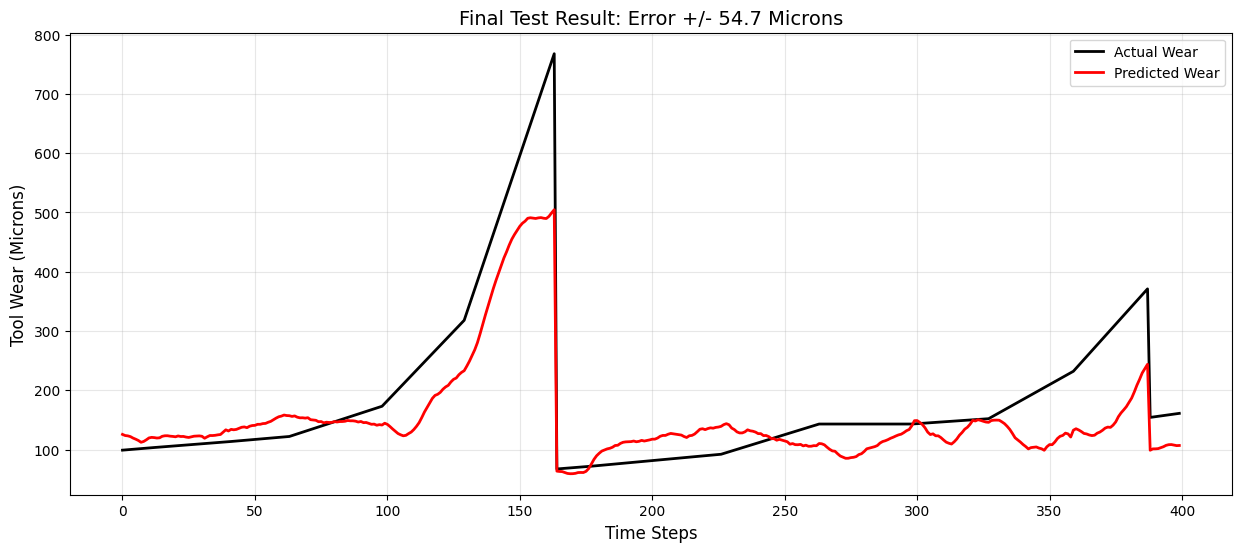

In [51]:
tool_ids = sorted(list(df_per_tool.keys()))
n_tools = len(tool_ids)
split_idx = int(n_tools * split_ratio)
val_idx = int(split_idx * split_ratio)

train_ids = tool_ids[:val_idx]

train_dfs = [df_per_tool[tid] for tid in train_ids]
combined_train = pd.concat(train_dfs, axis=0)

scaler_recovery = StandardScaler()
scaler_recovery.fit(combined_train)

target_mean = scaler_recovery.mean_[-1]
target_scale = scaler_recovery.scale_[-1]

print(f"Recovered Scaler Stats -> Mean: {target_mean:.4f}, Scale: {target_scale:.4f}")

print("Predicting on Test Set...")
y_pred_scaled = lstm_final_model.predict(X_test)

y_test_microns = (y_test * target_scale) + target_mean
y_pred_microns = (y_pred_scaled.flatten() * target_scale) + target_mean

mae = mean_absolute_error(y_test_microns, y_pred_microns)
rmse = np.sqrt(mean_squared_error(y_test_microns, y_pred_microns))

print("-" * 40)
print(f"Mean Absolute Error: {mae:.2f} Microns")
print(f"Root Mean Squared Error: {rmse:.2f} Microns")
print("-" * 40)

plt.figure(figsize=(15, 6))
limit = 400
plt.plot(y_test_microns[:limit], label='Actual Wear', color='black', linewidth=2)
plt.plot(y_pred_microns[:limit], label='Predicted Wear', color='red', linewidth=2)

plt.title(f'Final Test Result: Error +/- {mae:.1f} Microns', fontsize=14)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Tool Wear (Microns)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [52]:
class Embeddings(layers.Layer):
  def __init__(self,seq_len,output_dim):
    super(Embeddings,self).__init__()
    self.feature_embedding = layers.Dense(output_dim)
    self.position_embedding = layers.Embedding(seq_len,output_dim)
  def call(self,inputs):
    feature_embedding = self.feature_embedding(inputs)
    position = tf.range(start=0,limit=tf.shape(inputs)[-2],delta=1)
    position_embedding = self.position_embedding(position)
    return feature_embedding + position_embedding

class TransformerBlock(layers.Layer):
  def __init__(self,embed_dim,head_size,num_heads,ff_dim,dropout=0.25):
    super(TransformerBlock,self).__init__()
    self.attention = layers.MultiHeadAttention(num_heads=num_heads,key_dim=head_size)
    self.dropout = layers.Dropout(dropout)
    self.norm1 = layers.LayerNormalization(epsilon=1e-6)
    self.norm2 = layers.LayerNormalization(epsilon=1e-6)
    self.conv1d_1 = layers.Conv1D(filters = ff_dim,kernel_size=1,activation='relu')
    self.conv1d_2 = layers.Conv1D(filters=embed_dim,kernel_size=1)
  def call(self,inputs,training=False):
    x = self.attention(inputs,inputs)
    x = self.dropout(x,training=training)
    x = self.norm1(x+inputs)
    res = x
    x = self.conv1d_1(x)
    x = self.dropout(x,training=training)
    x = self.conv1d_2(x)
    x = self.dropout(x,training=training)
    return self.norm2(x+res)

def build_transformer(input_shape,params):
  inputs =  Input(shape=input_shape)
  x = Embeddings(input_shape[0],128)(inputs)

  for _ in range(4):
    x = TransformerBlock(embed_dim=128,head_size=params['head_size'], num_heads=4, ff_dim=params['ff_dim'], dropout=params['dropout_rate'])(x)
  x = layers.GlobalAveragePooling1D()(x)
  x = layers.Dropout(params['dropout_rate'])(x)
  x = layers.Dense(units = 64,activation='relu')(x)
  outputs = layers.Dense(units=1,activation='linear')(x)
  model =  models.Model(inputs,outputs)
  model.compile(optimizer=AdamW(learning_rate=params['learning_rate'],weight_decay=params['weight_decay']), loss = 'mean_squared_error')
  return model

trans_params = {
    'head_size': 64,
    'ff_dim': 128,
    'dropout_rate': 0.2,
    'learning_rate': 1e-4,
    'weight_decay': 1e-4
}
print("Training Transformer...")
trans_model = build_transformer((X_train.shape[1],X_train.shape[2]), trans_params)

trans_early_stopping =  EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = trans_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[trans_early_stopping],
    verbose=1
)

print("\n--- RESULTS ---")
loss = trans_model.evaluate(X_test, y_test, verbose=0)
print(f"Transformer MSE (Scaled): {loss:.4f}")

y_pred = trans_model.predict(X_test)
y_pred_microns = (y_pred.flatten() * target_scale) + target_mean
mae = mean_absolute_error(y_test_microns, y_pred_microns)
print(f"Transformer Error: {mae:.2f} Microns")

Training Transformer...
Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 0.9069 - val_loss: 2.1737
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2766 - val_loss: 0.9521
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1224 - val_loss: 0.8033
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0883 - val_loss: 0.7244
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0704 - val_loss: 0.9789
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0744 - val_loss: 0.9084
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0599 - val_loss: 0.9458
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0552 - val_loss: 0.8774
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0516 - val_loss: 0.9057
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0467 - val_loss: 1.0116
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0390 - val_loss: 0.8392
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0

LSTM Error: 54.69 Microns
Transformer Error:77.37 Microns


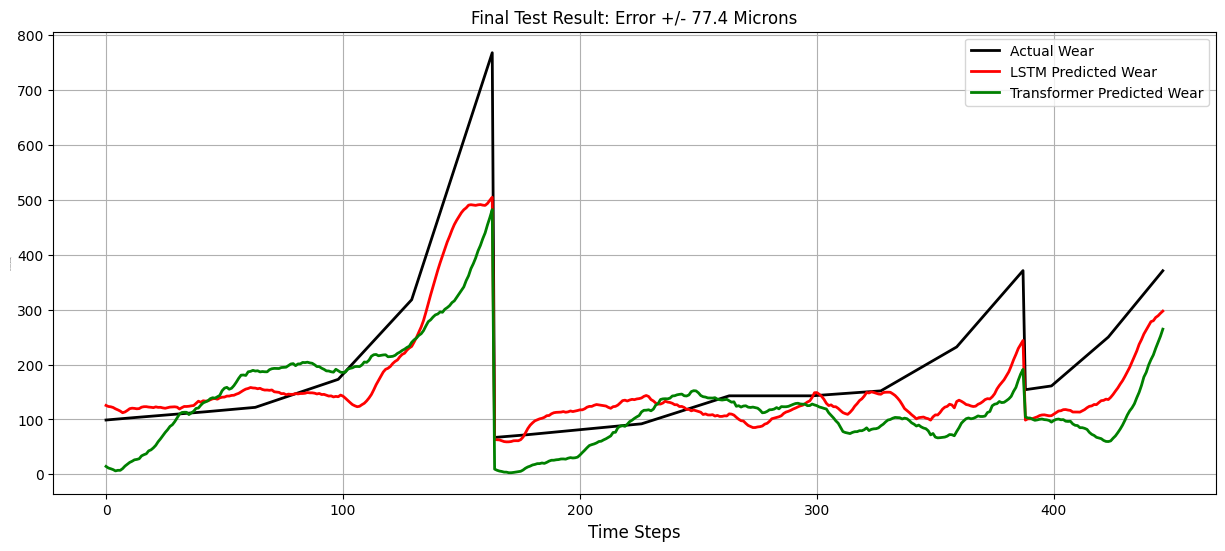

In [53]:
lstm_y_pred = lstm_final_model.predict(X_test,verbose=0)
lstm_pred_microns = (lstm_y_pred.flatten()*target_scale)+target_mean
lstm_mae = mean_absolute_error(y_test_microns,lstm_pred_microns)
print(f"LSTM Error: {lstm_mae:.2f} Microns")

trans_y_pred = trans_model.predict(X_test,verbose=0)
trans_pred_microns = (trans_y_pred.flatten()*target_scale)+target_mean
trans_mae = mean_absolute_error(y_test_microns,trans_pred_microns)
print(f'Transformer Error:{trans_mae:.2f} Microns')

plt.figure(figsize=(15,6))
limit=500
plt.plot(y_test_microns[:limit],label='Actual Wear',color='black',linewidth=2)
plt.plot(lstm_pred_microns[:limit],label='LSTM Predicted Wear',color='red',linewidth=2)
plt.plot(trans_pred_microns[:limit],label='Transformer Predicted Wear',color='green',linewidth=2)
plt.title(f'Final Test Result: Error +/- {mae:.1f} Microns')
plt.xlabel('Time Steps',fontsize=12)
plt.ylabel('Tool Wear (Microns)',fontsize=1)
plt.grid()
plt.legend()
plt.show()